In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import pandas as pd
import xarray as xr
from sklearn.preprocessing import scale
import scipy
from scipy.special import expit

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


If you cannot solve the proposed problem try to solve first some related problem. Could you imagine a more accessible related problem? A more general problem? A special problem? An analogous problem?

Move laterally when stuck

Try a simpler model first, then return to the more complex problem


## Can't always get what you want

Ask what you can get, sensitivity analysis, mediators.

## Trolley Problems

Data:

- Different trolley problems/moral questions with principles in opposition

- Ask for response regarding moral intuition

- Attempt to empirically study the ethics of moral problems.

- 3 latent features: Action, Intention, Contact

- 331 individuals (age,gender,edu)

- Voluntary participation (online)

- 30 different trolley problems

- action/intention/contact varied 

- 9930 responses: How appropriate (1-7)?

In [2]:
trolley = pd.read_csv('Data/Trolley.csv',sep=';')

trolley.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


array([[<AxesSubplot: title={'center': 'response'}>]], dtype=object)

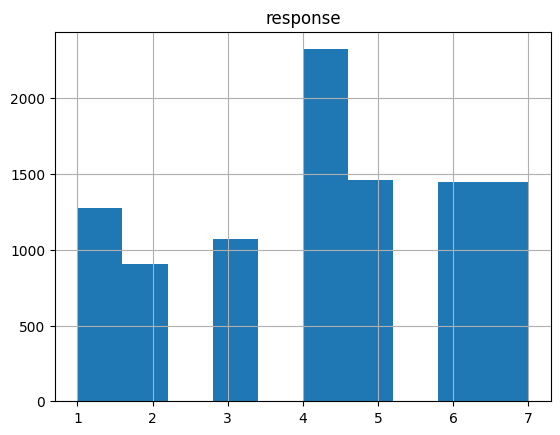

In [3]:
trolley.hist(column='response')
#Not metric, bounded, odd distribution

Estimand: How do action, intention, contact influence response to a trolley story? 

How are influences of A/I/C associated with other variables?

## Ordered Categories

Categories: Discrete types

Ordered categories: Discrete types with ordered relationships

bad, good, excellent (7 is more than 1, just don't know by how much)

Probably much easier to go from 4 to 5 than from 6 to 7

Anchor points common (like 4 in our data)

Not everyone shares the same anchor points 

## Ordered = Cumulative

Adds the previous result to the next result. 

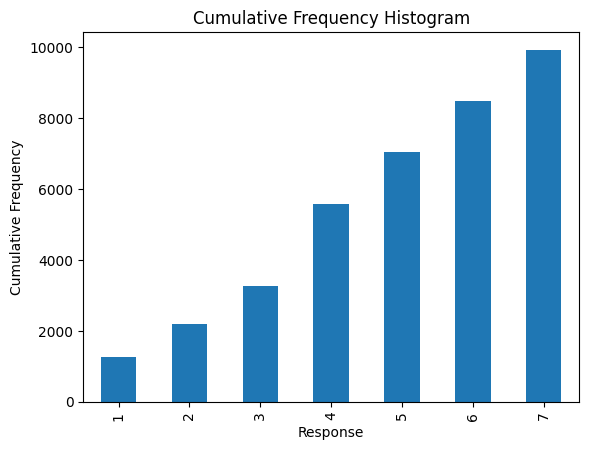

In [4]:
cumulative_sum = trolley['response'].value_counts().sort_index().cumsum()

cumulative_sum.plot(kind='bar')
plt.title('Cumulative Frequency Histogram')
plt.xlabel('Response')
plt.ylabel('Cumulative Frequency')
plt.show()

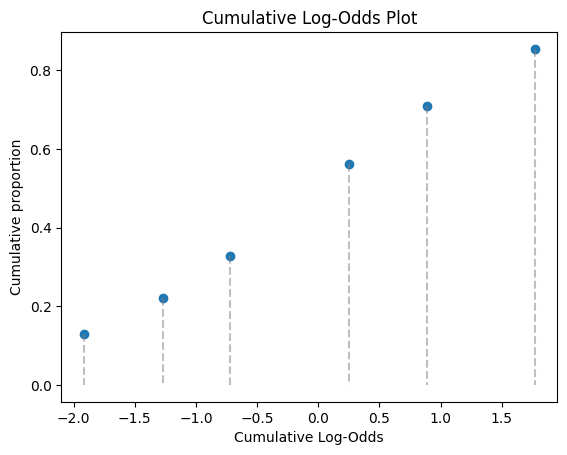

In [5]:
# Calculate the cumulative probability of each response
cumulative_prob = cumulative_sum/cumulative_sum.iloc[-1]
# Calculate the cumulative log-odds
cumulative_log_odds = np.log(cumulative_prob / (1 - cumulative_prob))
# Plot the cumulative log-odds
#cumulative_log_odds.plot(kind='bar')
plt.scatter(x=cumulative_log_odds,y=cumulative_prob)

for x, y in zip(cumulative_log_odds, cumulative_prob):
    plt.plot([x, x], [y, 0], '--', color='gray', alpha=0.5)

plt.title('Cumulative Log-Odds Plot')
plt.xlabel('Cumulative Log-Odds')
plt.ylabel('Cumulative proportion')
plt.show()


Going to use log-odds (logit links). Need to translate probability to log-odds. 

Gives cumulative log-odds. Each point is the cutpoint

The number of cutpoints you need is 1 less that the number of outcomes, last one is free and is whatever is left over. The outcomes live inthe gaps between the cuts, last one lives off to the right into infinity because everything after that cutpoint must be 7 (in our example).  

Pr(R = k) = Pr(R<= 3) - Pr(R<=2)

Gives discrete categories, force order. 

log(Pr(R <= k) / (1-Pr(R<=k)) = a

left is cumulative log odds
a is the cutpoint to estimate 


## Where's the GLM?

So far just estimating the histogram

How to make it a function of variables?

1) Stratify cutpoints

2) Offset each cutpoint by value of linear model  phi. 

Ri ~ OrderedLogit(phi,alpha)

bigger phis give you smaller average responses, opposite for smaller phis. usually subtract phi . 

In [6]:
trolley['action'].shape

(9930,)

In [7]:
trolley['response'].values -1

array([3, 2, 3, ..., 6, 1, 1], dtype=int64)

In [10]:
# Starting off easy
with pm.Model() as easy_trolley:
    A     = pm.MutableData('A',trolley['action'].values)
    I     = pm.MutableData('I',trolley['intention'].values)
    C     = pm.MutableData('C',trolley['contact'].values)
    R     = pm.MutableData('R',trolley['response'].values -1) # 0-6 instead of 1-7
    
    #Cutpoints instead of alpha
    #cutpoints = pm.Normal('cutpoints',0,1)#,transform = pm.distributions.transforms.ordered)#,shape=6)
    cutpoints = pm.Normal(
        "cutpoints",
        0.0,
        1.5,
        transform=pm.distributions.transforms.Ordered,
        shape=6,
        testval=np.arange(6) - 2.5,
    )
    bA    = pm.Normal('bA',0,0.5)
    bI    = pm.Normal('bI',0,0.5)
    bC    = pm.Normal('bC',0,0.5)
    
    phi   = pm.Deterministic('phi',bA*A + bI*I + bC*C)
    
    Response     = pm.OrderedLogistic('Response', cutpoints=cutpoints,eta = phi,observed=R,shape=R.shape)
    easy_trace = pm.sample()
    
    #Doesn't like the shape thing, very odd

C:\Users\kmcg2831\AppData\Local\Temp\ipykernel_12860\1305428230.py:10: FutureWarning: The `testval` argument is deprecated; use `initval`.
  cutpoints = pm.Normal(


AttributeError: 'RandomGeneratorSharedVariable' object has no attribute 'shape'

## Will continue to fix these models, not sure why they're breaking

Voluntary sample, participation P is influenced by E, Y and G. 

Thus E,Y,G covary in sample. P is a collider

## Endogenous Selection

Sample is selectd on a collider

Induces misleading associations among variables

Not possible here to estimate total effect of G, BUT can get direct effect

Need to stratify by E and Y and G 


## Ordered monotonic predictors

Education is an ordered category

Unlikely that each level has same effect

Want a parameter for each level

But how to enforce ordering, so that each level has larger? (or smaller) effect that previous?

Each increment will get a new increment

1 = phi = 0
2 = phi = del1
3 = phi = del1 + del2 

phi = B * education level*proportion of maximum effect)


How do we set priors for the delta parameters?

delta parameters form a simplex

Simplex: vector that sums to 1

del ~ Dirichlet(a)
a = [some vector]

The bigger the elements of the a are, the smaller the difference between them .



In [ ]:
with pm.Model() as gender_m:
    delta = 